# *Visualizing SLaPkNN with M<N Prototypes*
1. Run the first cell to start the visualization.
2. Use the 'Mode' dropdown to choose a method of positioning prototypes. 
3. Use num_points and num_classes to control M and N, respectively.
4. Setting a higher resolution improves accuracy but may slow down computation.
5. To save the image, first type desired filename in the provided blank, then press the save button.

<IPython.core.display.Javascript object>


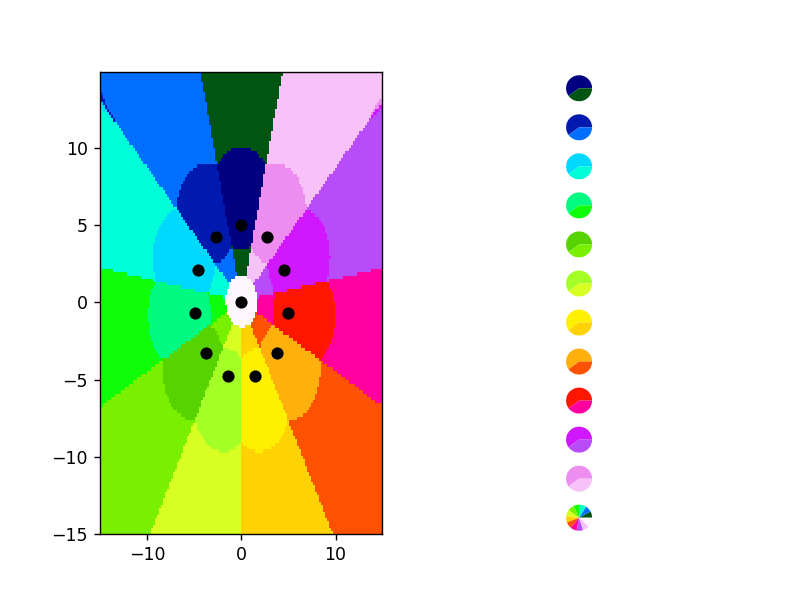

Button(description='Save image', style=ButtonStyle())

Output()

interactive(children=(IntSlider(value=10, continuous_update=False, description='frame', max=60, min=-60, step=…

In [19]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from soft_knn import SoftKNN
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import fractions
import itertools
from collections import Counter


def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
def create_system(n, verbose=False):
    A=[]
    for i in range(1,int(np.ceil(n/2.))):
        for j in range(2*i, n):#int(np.floor(n/2.))+i
            vector = np.zeros(n)
            vector[i-1]+=(1./(j/2.))
            vector[n-i+1-1]+=(1/(n-(j/2.)))
            vector[j-i+1-1]+=(-1./(j/2.))
            vector[n-j+i-1]+=(-1/(n-(j/2.)))
            A.append(vector)
            if verbose:
                print ("(y_{0}/{1})+(y_{2}/{3}) = (y_{4}/{1}) + (y_{5}/{3})    ".format(i,j/2.,n-i+1,n-(j/2.),j-i+1,n-j+i))
        if verbose: 
            print("\n")
    A.append(np.ones(n))
    A.append(np.zeros(n))
    A[-1][-1]=1
    b = np.zeros(len(A))
    b[-2]=1
    return A, b
def solve_system(A,b):
    soln, _, _, _ = np.linalg.lstsq(A,b,rcond=None)
    return soln
def labels_2_points_n_classes(n):
    denom = sum([j**2 for j in range(1,n)])
    y=[(n*(n-1)-i*(i-1))/denom for i in range(1,n+1)]
    y=[elem/sum(y) for elem in y]
    return y
def expected_num_eqns(n):
    return (np.ceil(n/2.)-1)*(n-np.ceil(n/2.))
    

ims=[]
fig=plt.figure()


def animate(frame, num_points, num_classes, mode, resolution, zoom, filename, k, normalize):
    
    #frame+=20
    ax_list=fig.axes
    [fig.delaxes(ax) for ax in ax_list]
    ax1 = fig.add_subplot(1,2,1)
    axs = [fig.add_subplot(num_points,2,2*(point+1)) for point in range(num_points)]
    if mode == "poly_and_center":
        frame+=20
        num_classes = 2*(num_points-1)+num_points
        polygon = matplotlib.patches.RegularPolygon((0,0),num_points-1, radius=5)
        dd=polygon.get_verts()[:-1]
        dd=np.append(dd,np.array([[0,0]]),axis=0)
        dy=np.zeros((num_points,num_classes))
        for i in range(num_points-1): 
            #Set the surrounding polygon classes
            dy[i][2*i]=0.4-frame*0.0012
            dy[i][(2*i+1)%(2*(num_points-1))]=0.2+frame*0.0004
            dy[i][(2*i-1)%(2*(num_points-1))]=0.2+frame*0.0004
            dy[i][(2*(num_points-1)+i)]=0.2+frame*0.0004
            #Set the central classes
            dy[-1][(2*(num_points-1)+i)]=0.2+frame*0.0004
        dy[-1][-1]=0.4-frame*0.0004*(num_points-1)
    if mode == "pairs_with_center":
        num_classes = 2*(num_points-1)+1
        polygon = matplotlib.patches.RegularPolygon((0,0),num_points-1, radius=5)
        dd=polygon.get_verts()[:-1]
        dd=np.append(dd,np.array([[0,0]]),axis=0)
        dy=np.zeros((num_points,num_classes))
        solutions = labels_2_points_n_classes(3)
        for i in range(num_points-1): 
            #Set the surrounding polygon classes
            dy[i][2*i]=solutions[0]
            dy[i][2*i+1]=solutions[1]
            dy[i][-1] = solutions[2]
            #Set the central classes
            dy[-1][2*i]=solutions[2]
            dy[-1][2*i+1]=solutions[1]
        dy[-1][-1]=solutions[0]
        if normalize:
            mag=sum(dy[-1])
            for i in range(len(dy[-1])):
                dy[-1][i]/=mag
    if mode =="every_other":
        num_classes = 2*num_points
        polygon = matplotlib.patches.RegularPolygon((0,0),num_classes, radius=5)
        dd=polygon.get_verts()[:-1:2]
        dy=np.zeros((num_points,num_classes))
        for i in range(num_points):
            dy[i][2*i]=0.49-frame*0.001
            dy[i][(2*i+1)%num_classes]=0.255+frame*0.0005
            dy[i][(2*i-1)%num_classes]=0.255+frame*0.0005
    if mode == "poly_every_subset":
        num_classes = 2**num_points - 1
        polygon = matplotlib.patches.RegularPolygon((0,0),num_points, radius=5)
        dd=polygon.get_verts()[:-1]
        dy=np.full((num_points,num_classes),num_points/num_classes)
        #Incomplete
    if mode == "2points_n_classes":
        dd=np.array([[0,0],[1,0]])
        dy=np.zeros((num_points,num_classes))
        
        dy[0] = labels_2_points_n_classes(num_classes)
        #A, b = create_system(num_classes)
        #dy[0]=solve_system(A,b)
        
#         if num_classes ==3:
#             dy[0]=np.array([3/5,2/5,0])
#         if num_classes==4:
#             #dy[0]=np.array([5/12,4/12,3/12,0])
#             dy[0]=np.array([6/14,5/14,3/14,0])
#         if num_classes==5:
#             dy[0]=np.array([60/200,49/200,47/200,44/200,0])
#         if num_classes==6:
#             dy[0]=np.array([56/210,52/210,42/210,40/210,20/210,0])

     
        dy[1]=dy[0][::-1]
        print(dy)
    if mode == "2points_half_n_classes":
        num_classes=2*num_classes
        dd=np.array([[0,0],[1,0]])
        dy=np.zeros((num_points,num_classes))
        
        dy[0] = labels_2_points_n_classes(num_classes)
        dy[1]=dy[0][::-1]  
        half_ind = int((num_classes+1)/2)
        dy[0][half_ind:]=np.zeros_like(dy[0][half_ind:])
        dy[1][half_ind:]=np.zeros_like(dy[1][half_ind:])
        
    if mode == "3points_n_classes":
        dd=np.array([[-1,0],[0,0],[1,0]])
        dy=np.zeros((num_points,num_classes))
        
        dy[0] = labels_2_points_n_classes(num_classes)
        #A, b = create_system(num_classes)
        #dy[0]=solve_system(A,b)
        
#         if num_classes ==3:
#             dy[0]=np.array([3/5,2/5,0])
#         if num_classes==4:
#             #dy[0]=np.array([5/12,4/12,3/12,0])
#             dy[0]=np.array([6/14,5/14,3/14,0])
#         if num_classes==5:
#             dy[0]=np.array([60/200,49/200,47/200,44/200,0])
#         if num_classes==6:
#             dy[0]=np.array([56/210,52/210,42/210,40/210,20/210,0])

     
        dy[1]=dy[0][::-1] 
        dy[2]=dy[0]  
        
    if mode == "3points_half_n_classes":
        num_classes=2*num_classes

        dd=np.array([[-1,0],[0,0],[1,0]])
        dy=np.zeros((num_points,num_classes))
        
        dy[1] = labels_2_points_n_classes(num_classes)

     
        dy[0]=dy[1][::-1] 
        dy[2]=dy[0]  
        half_ind = int((num_classes+1)/2)
        dy[0][half_ind:]=np.zeros_like(dy[0][half_ind:])
        dy[1][half_ind:]=np.zeros_like(dy[1][half_ind:])
        dy[2][half_ind:]=np.zeros_like(dy[2][half_ind:])
    #print(dy)
    if not mode != "true":
        distX=[]
        distY=[]
        for i in range(num_points):
            class_list = []
            for j in range(num_classes):
                class_list.append(int(dy[i][j]*granularity)+1*(mode!="2points_n_classes"))
                distY.append(np.repeat(j, class_list[-1]))
            #print(class_list)
            #class_list.append(granularity-sum(class_list))
            #print(class_list)
            #distY.append(np.repeat(i, class_list[-1]))
            distX.append(np.repeat([dd[i]], sum(class_list),axis=0))
            #tempy=
            
            
        distX=np.concatenate(distX)
        distY=np.concatenate(distY)
    distX=dd
    distY=dy
        #print(distX)
        #print(distY)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFA8E8', '#A8FFE8', '#E8A8FF', '#E8FFA8' ])
    cmap_bold = ListedColormap(['#FF8888', '#88FF88', '#8888FF', '#994282', '#429982', '#824299' ,'#829942' ])
    cmap_bolder = ListedColormap(['#000000', '#000000', '#000000'])
    colors=['#FFAAAA', '#AAFFAA', '#AAAAFF']
    if num_classes>20:
        cmap="gist_ncar"
    else:
        cmap="tab20"
    cmap_single = get_cmap(num_classes, cmap)
    colors=cmap_single(range(num_classes))
    # create KNN classifier
    clf = SoftKNN(k=k)
    #clf = neighbors.KNeighborsClassifier(min(n_neighbors, len(distX)), weights=weights)
    clf.fit(distX, distY)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if mode=="2points_n_classes":
        x_min, x_max = -0-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="2points_half_n_classes":
        x_min, x_max = -0-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="3points_n_classes":
        x_min, x_max = -1-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="3points_half_n_classes":
        x_min, x_max = -1-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="every_other":
        x_min, x_max = -20,20
        y_min, y_max = -20,20
    elif mode=="pairs_with_center":
        x_min, x_max = -15,15
        y_min, y_max = -15,15
    else:
        x_min, x_max = -10,10
        y_min, y_max = -10,10
    size = (x_max-x_min)*(y_max-y_min)
    desired_particles = 12000./resolution
    h = (size/desired_particles)**0.5  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax1.clear()
    ax1.pcolormesh(xx, yy, Z, cmap=cmap_single)
    if not mode =="true": 
        ax1.scatter(distX[:, 0], distX[:, 1], c="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    #plt.title("3-Class classification (k = %i)")
    for i in range(num_points):
        axs[i].pie(dy[i], colors=colors)

    if mode== "2points_n_classes":
        axs[0].title.set_text("Left")
        axs[1].title.set_text("Right")


#play = widgets.Play(
#      value=50,
#      min=0,
#      max=100,
#      step=1,
#      interval=2000,
#      description="Press play",
#     disabled=False
#  )
# slider=widgets.IntSlider()
# widgets.jslink((play, 'value'), (slider, 'value'))
# widgets.HBox([play, slider])
#interact(animate,frame=10)
frame=widgets.IntSlider(min=-60, max=60, value=10, step=10, continuous_update=False)
num_points=widgets.IntSlider(min=2, max=12, continuous_update=False)
num_classes=widgets.IntSlider(min=2, max=24, disabled=True, continuous_update=False)
k_nearest=widgets.IntSlider(min=1, max=24, value=2, disabled=False, continuous_update=False)
mode=widgets.Dropdown(
    options=['poly_and_center', 'every_other', 'pairs_with_center', '2points_n_classes', '3points_n_classes','2points_half_n_classes', '3points_half_n_classes'],
    value='every_other',
    description='Mode:',
    disabled=False,
)
resolution = widgets.RadioButtons(
    options=[("Very Low",1.0),("Low",0.8),("Medium",0.6),("High", 0.4),("Very High", 0.2)],
    description='Resolution:',
    value=0.6,
    disabled=False
)
zoom = widgets.IntSlider(min=-5, max=5, value=5, step=1, continuous_update=False, disabled=True)
filename=widgets.Text(
    value='image.png',
    placeholder='image.png',
    description='Filename:',
    disabled=False
)
normalize=widgets.Checkbox(
    value=False,
    description='Normalize',
    disabled=False,
    indent = False
)
# save=widgets.Button(
#     description='Save Image')
# output = widgets.Output()

# display(save, output)
# def on_save(b):
#     with output:
#         plt.savefig("abc")
# save.on_click(on_save)
from IPython.display import display
button = widgets.Button(description='Save image')
output = widgets.Output()
display(button, output)
def on_save(b):
    with output:
        plt.savefig(filename.value)


button.on_click(on_save)



def update_points_range(*args):
    if mode.value=="every_other":
        num_classes.max=2*num_points.max
        num_classes.min=1
        num_classes.value = num_points.value*2
        num_classes.disabled=True
        num_points.disabled=False
        new_max_points = 12
        new_min_points = 4
        frame.disabled=False
        zoom.disabled=True
    if mode.value=="poly_and_center":
        num_points.disabled=False
        new_max_points = 12
        new_min_points = 4
        num_classes.max=3*num_points.max-2
        num_classes.min=1
        num_classes.value = 3*num_points.value-2
        num_classes.disabled=True
        frame.disabled=False
        zoom.disabled=True
    if mode.value=="pairs_with_center":
        num_points.disabled=False
        new_max_points = 12
        new_min_points = 4
        num_classes.max=2*num_points.max+1
        num_classes.min=1
        num_classes.value = 2*num_points.value-1
        num_classes.disabled=True
        frame.disabled=False
        zoom.disabled=True
    if mode.value=="2points_n_classes":
        new_min_points = 2
        new_max_points = 2
        num_points.value = 2
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if mode.value=="2points_half_n_classes":
        new_min_points = 2
        new_max_points = 2
        num_points.value = 2
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if mode.value=="3points_n_classes":
        new_min_points = 3
        new_max_points = 3
        num_points.value = 3
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if mode.value=="3points_half_n_classes":
        new_min_points = 3
        new_max_points = 3
        num_points.value = 3
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if new_min_points > num_points.max:
        num_points.max = new_max_points
        num_points.min=new_min_points
    else:
        num_points.min = new_min_points
        num_points.max = new_max_points
    k_nearest.max=num_points.max
        
mode.observe(update_points_range, 'value')
num_points.observe(update_points_range)
interactive_plot=interactive(animate,frame=frame, num_points=num_points, num_classes=num_classes,k=k_nearest, mode=mode, resolution=resolution, zoom=zoom, filename=filename, normalize=normalize)
output = interactive_plot.children[-1]
output.layout.height = '350px'

interactive_plot



In [14]:
def create_system(n, verbose=False):
    A=[]
    for i in range(1,int(np.ceil(n/2.))):
        for j in range(2*i, n):#int(np.floor(n/2.))+i
            vector = np.zeros(n)
            vector[i-1]+=(2*n-j)
            vector[n-i+1-1]+=(j)
            vector[j-i+1-1]+=(-(2*n-j))
            vector[n-j+i-1]+=(-j)
            A.append(vector)
            if verbose:
                print ("(y_{0}/{1})+(y_{2}/{3}) = (y_{4}/{1}) + (y_{5}/{3})    ".format(i,j/2.,n-i+1,n-(j/2.),j-i+1,n-j+i))
        if verbose: 
            print("\n")
    A.append(np.ones(n))
    A.append(np.zeros(n))
    A[-1][-1]=1
    b = np.zeros(len(A))
    b[-2]=1
    return A, b

def do_stuff():
    n=8
    A,b=create_system(n, verbose=False)
    print ("Expected: {0} Found: {1}".format(expected_num_eqns(n),len(A)-2))
    print("".join([str(a)+"\n" for a in A]))

    C=A[:(n-2)]
    C.append(A[-1])
    C.append(A[-2])
    # if n%2==1:
    #C.append(A[-3])
    print(np.linalg.matrix_rank(C))
    def solve_system(A,b):
        soln, rsq, _, _ = np.linalg.lstsq(A,b,rcond=None)
        return soln, rsq
    #print(solve_system(A,b))
    soln=solve_system(A,b)[0]
    print([str(fractions.Fraction(i).limit_denominator()) for i in soln])
    choices = np.transpose(np.array(A[:n-2]))
    #print(choices)
    target=A[n-2+n-4]
    #print(target)
    soln=solve_system(choices, target)
    #[str(fractions.Fraction(i).limit_denominator()) for i in soln[0]]